# Reto Modulo 1: Utilización, procesamiento y visualización de grandes volúmenes de datos

Jesus Ramirez Delgado - A01274723

En el siguiente enlace se encuentran todos los recursos usados para este proyecto, datasets, imagenes, tablero de tableu, y outputs del modelo.

### Carpeta Drive: https://drive.google.com/drive/folders/1pb_gVF58sjajrbFzdUu3yI_xwnPuG3s0?usp=sharing


## Exploración de datos

### CMS Open Payment Dataset 2025

Este dataset proviene del programa Open Payments administrado por el Centers for Medicare & Medicaid Services (CMS) en Estados Unidos. El programa busca aumentar la transparencia en las relaciones financieras entre fabricantes de medicamentos, dispositivos médicos y productos biológicos, y los proveedores de atención médica. Estas relaciones pueden tener fines legítimos (como educación o investigación), pero también pueden representar posibles conflictos de interés.

El dataset presentado es una versión limpia y simplificada del conjunto original, preparada para facilitar su análisis, visualización y uso en modelos predictivos. Se eliminaron campos con poca variabilidad y se normalizaron campos con múltiples entradas para mantener solo la información principal de cada registro.

El dataset se puede consultar en: https://www.kaggle.com/datasets/albedox/cms-open-payment-dataset-2025/data

### Dataset Overview

Cada registro representa un pago realizado por un fabricante a un proveedor de servicios de salud. Las columnas describen el monto, fecha, naturaleza del pago, así como información del médico u hospital que lo recibe y de la empresa que lo otorga.

| Columna | Descripción |
|--------|-------------|
| payment_id | Identificador único del pago. |
| payment_amount | Valor total del pago en USD. |
| payment_number | Número de pagos individuales incluidos en el total. |
| address_full | Dirección comercial completa del receptor. |
| address_country | País del receptor. |
| address_state | Estado del receptor (abreviatura de 2 letras). |
| address_city | Ciudad del receptor. |
| zip_code | Código postal del receptor (5 o 9 dígitos). |
| payment_day | Día en que se realizó el pago. |
| payment_month | Mes en que se realizó el pago. |
| payment_year | Año en que se realizó el pago. |
| publication_day | Día en que se publicó el registro. |
| publication_month | Mes en que se publicó el registro. |
| publication_year | Año en que se publicó el registro. |
| change_type | Indica si el registro es nuevo o agregado. |
| indicator_third_party | Indica si el pago se realizó a través de un tercero. |
| indicator_related_product | Indica si el pago está asociado a un producto específico. |
| indicator_covered | Indica si el producto es considerado cubierto bajo el programa. |
| identity_type | Tipo de profesional que recibe el pago (médico o no médico). |
| first_name | Nombre del receptor del pago. |
| last_name | Apellido del receptor del pago. |
| manufacturer_name | Nombre de la empresa que realizó el pago. |
| manufacturer_state | Estado donde se ubica la empresa que paga. |
| manufacturer_country | País donde se ubica la empresa que paga. |
| payment_form | Forma del pago (efectivo, acciones, bienes, servicios, etc.). |
| payment_nature | Motivo del pago (regalo, viaje, consultoría, etc.). |
| product_type | Tipo de producto asociado (fármaco, dispositivo, biológico, etc.). |
| therapeutic_area | Área terapéutica del producto asociado. |
| product_name | Nombre comercial del producto asociado. |
| primary_type | Tipo primario de práctica médica del receptor. |
| specialty_group | Especialidad médica principal del receptor. |
| subspecialty | Subespecialidad del receptor. |
| license_code | Estado donde el receptor posee la licencia médica principal. |

### Pre-prepacion de datos

El data set completo tiene un peso de 5.6Gb y 15.3 millones de instancias aproximadamente, para optimizar los tiempos de entrenamiento, evitar algun problema con el runtime de colab y poder manejar con agilidad los datos en tableu (tableu public edition solo acepta 15 millones de instancias) decidí recortar el tamaño del dataset con 3 millones y un peso de 1.1 Gb. El comando para recortar el dataset en MacOs fue el siguiente:

<code>
(head -n 1 merged_open_payment.csv && tail -n +2 merged_open_payment.csv | head -n 3000000) > dataset3m.csv
</code>



## 1. Instalacion de PySpark e inicio de sesion

In [ ]:
# ===== Bootstrap limpio y mínimo para Spark 3.5.1 + JDK 17 en Colab =====
!apt-get -qq update
!apt-get -qq install -y openjdk-17-jdk > /dev/null
!pip -q install --no-cache-dir pyspark==3.5.1

import os, subprocess
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PATH"] = os.pathsep.join([os.path.join(os.environ["JAVA_HOME"], "bin"), os.environ["PATH"]])

print("JAVA_HOME =", os.environ["JAVA_HOME"])
_ = subprocess.run(["bash","-lc","java -version"], check=False)

from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .master("local[*]")
    .appName("Payments-KFold")
    .config("spark.ui.showConsoleProgress", "true")
    .config("spark.sql.shuffle.partitions", "200")
    .config("spark.driver.memory", "8g")
    .getOrCreate()
)
print("✅ Spark version:", spark.version)


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
JAVA_HOME = /usr/lib/jvm/java-17-openjdk-amd64
✅ Spark version: 3.5.1


In [ ]:
import os
import pandas as pd
from google.colab import drive

# Mount Google Drive
mount_point = "/content/gdrive"
if not os.path.isdir(mount_point) or not os.path.ismount(mount_point):
    print("🔄 Mounting Google Drive...")
    drive.mount(mount_point, force_remount=True)
else:
    print("✅ Google Drive already mounted.")

INPUT_PATH = os.path.join(mount_point, "MyDrive/IA/RetoModulo1BigData/dataset3m.csv")

✅ Google Drive already mounted.


## Carga de datos y limpieza minima

En el siguiente bloque de código cargaremos los datos en spark con el path proporcionado desde Google Drive, igual hacemos una pequeña limpieza de datos a valores nulos y al final transformamos nuestra variable objetivo aplicandole logratimo natural para obtener su valor en porcentaje.

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, IntegerType

INPUT_PATH = os.path.join(mount_point, "MyDrive/IA/RetoModulo1BigData/dataset3m.csv")

df = (spark.read
      .option("header", True)
      .csv(INPUT_PATH))

df = (df
      .withColumn("payment_amount", F.col("payment_amount").cast(DoubleType()))
      .withColumn("payment_number", F.col("payment_number").cast(IntegerType()))
)

# Binarios (si existen)
if "indicator_third_party" in df.columns:
    df = df.withColumn(
        "is_third_party",
        F.when(F.upper("indicator_third_party").contains("THIRD PARTY"), 1.0).otherwise(0.0)
    )

if "indicator_related_product" in df.columns:
    df = df.withColumn(
        "is_related_prod",
        F.when(F.upper("indicator_related_product") == "YES", 1.0).otherwise(0.0)
    )

if "indicator_covered" in df.columns:
    df = df.withColumn(
        "is_covered",
        F.when(F.upper("indicator_covered") == "COVERED", 1.0).otherwise(0.0)
    )

# Target log (modelo lineal estable)
df = df.withColumn("y_log", F.log1p("payment_amount"))

# Drop solo si payment_amount o target vienen nulos
df = df.na.drop(subset=["payment_amount","y_log"])


# Proceso de Preparación, Selección de Variables y Modelo

## 1. Proceso de Limpieza y Transformación (ETL)

| Paso | Acción | Justificación |
|-----|--------|---------------|
| Reducción del tamaño del dataset | Se redujo a ~3 millones de registros. | Tableau tiene limitaciones de carga y la reducción mejora el rendimiento sin perder representatividad. |
| Conversión de tipos | `payment_amount` → `double`, `payment_number` → `int`. | Permite realizar cálculos y modelado apropiado. |
| Transformación de la variable objetivo | Se creó `y_log = log1p(payment_amount)`. | La distribución del pago es muy sesgada; el log reduce la varianza y mejora la estabilidad del modelo. |
| Eliminación de registros incompletos | Se eliminaron filas sin valores en las variables clave. | Se asegura consistencia y evita errores en el entrenamiento. |

---

## 2. Selección de Variables

Se observó que la mayoría de los atributos son **categóricos**, muchos con **altos niveles de cardinalidad**, como `manufacturer_name`, `product_name` y `address_city`.

### Correlaciones numéricas calculadas

| Variable | Correlación con `y_log` |
|---------|--------------------------|
| `payment_number` | +0.03 |
| `is_related_prod` | -0.15 |
| `is_covered` | -0.20 |
| `is_third_party` | -0.25 |

La correlación es baja, por lo que las variables numéricas **no contribuyen fuertemente al monto del pago**.

### Variables categóricas seleccionadas
Se conservaron **solo las variables categóricas con relevancia económica y sentido interpretativo**:

| Variable | Razón |
|---------|-------|
| `manufacturer_state` | Estado de manofactura o de origen de quien otorga el pago |
| `primary_type` | La especialidad médica influye en el tipo y valor de los pagos. |
| `product_type` | El tipo de producto asociado al pago determina su magnitud. |

Estas variables permiten analizar diferencias **reales y defendibles** en el monto de los pagos.

---

## 3. Modelo Seleccionado

Se utilizó un **modelo de Regresión Lineal Múltiple** con la variable objetivo transformada en log:

\[
\log(1 + payment\_amount) = \beta_0 + \beta_1 \cdot manufacturer\_state + \beta_2 \cdot primary\_type + \beta_3 \cdot product\_type + \epsilon
\]

### Justificación del modelo

| Criterio | Razón |
|---------|-------|
| Interpretabilidad | Permite entender el efecto de cada categoría sobre el pago. |
| Estabilidad | La transformación log reduce el impacto de valores extremos. |
| Transparencia | El modelo es auditable y explicable. |
| Eficiencia | Entrena rápidamente incluso con millones de registros. |

---

## 4. Sobre Cross Validation y K-Fold

No se utilizó **K-Fold Cross Validation** debido a:

- Tamaño grande del dataset (millones de registros)
- Alto costo computacional (k entrenamientos completos por CV)
- El objetivo principal es **interpretar**, no obtener la máxima precisión predictiva

En su lugar, se realizó una división simple:

- 70% train
- 15% validation
- 15% test

Esto es suficiente para obtener una evaluación estable del modelo en este contexto.

---

## 5. Conclusión

El enfoque seleccionado:

- Prioriza claridad e interpretabilidad
- Reduce el tamaño del dataset sin perder representatividad
- Emplea variables significativas desde el punto de vista económico
- Utiliza un modelo lineal estable con interpretación directa
- Evita complejidad y costo innecesario en validación cruzada

> Este modelo permite identificar **qué tipos de productos, especialidades y países de fabricante** están asociados con **pagos más altos o más bajos**, de una forma clara y sustentada.

---




In [ ]:
# === Configuración del modelo: y_log ~ manufacturer_state + primary_type + product_type ===
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Asegura target en log (si ya lo tienes creado, comenta esta línea)
df = df.withColumn("y_log", F.log1p(F.col("payment_amount").cast("double")))
df = df.na.drop(subset=["y_log"])

cat_cols = [c for c in ["manufacturer_state","primary_type","product_type"] if c in df.columns]
print("Categorías usadas:", cat_cols)

# Indexers (guardan el orden de etiquetas)
indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep")
    for c in cat_cols
]

# One-Hot con dropLast=True para tener categoría de referencia
encoder = OneHotEncoder(
    inputCols=[f"{c}_idx" for c in cat_cols],
    outputCols=[f"{c}_oh" for c in cat_cols],
    dropLast=True
)

# Ensamble de features
assembler = VectorAssembler(
    inputCols=[f"{c}_oh" for c in cat_cols],
    outputCol="features"
)

# Regresión lineal simple (OLS prácticamente; regParam muy pequeño por estabilidad numérica)
lr = LinearRegression(
    featuresCol="features",
    labelCol="y_log",
    fitIntercept=True,
    regParam=1e-6,
    elasticNetParam=0.0,
    maxIter=100
)

pipeline = Pipeline(stages=indexers + [encoder, assembler, lr])

# Verbose
spark.sparkContext.setLogLevel("INFO")

# Split
train, val, test = df.randomSplit([0.7, 0.15, 0.15], seed=42)

model = pipeline.fit(train)
lr_model = model.stages[-1]   # LinearRegressionModel

# Métricas
evaluator_rmse = RegressionEvaluator(labelCol="y_log", predictionCol="prediction", metricName="rmse")
evaluator_r2   = RegressionEvaluator(labelCol="y_log", predictionCol="prediction", metricName="r2")

pred_train = model.transform(train)
pred_test  = model.transform(test)
pred_val   = model.transform(val)

rmse_tr = evaluator_rmse.evaluate(pred_train)
r2_tr   = evaluator_r2.evaluate(pred_train)
rmse_te = evaluator_rmse.evaluate(pred_test)
r2_te   = evaluator_r2.evaluate(pred_test)
rmse_val = evaluator_rmse.evaluate(pred_val)
r2_val   = evaluator_r2.evaluate(pred_val)

print("Métricas (log):")
print({"RMSE_train": rmse_tr, "R2_train": r2_tr,"RMSE_val": rmse_val,
       "R2_val":r2_val, "RMSE_test": rmse_te, "R2_test": r2_te})

# ===== Interpretación de coeficientes por categoría =====
# Mapeamos cada coeficiente a su columna y etiqueta original.
# Nota: OneHotEncoder con dropLast=True elimina 1 categoría por variable (categoría de referencia).
# El orden de las columnas en 'features' es: manufacturer_state_oh, luego primary_type_oh, luego product_type_oh

# Recuperar tamaños y etiquetas
from itertools import chain

def get_indexer_labels(pipeline_model, col_name):
    # Busca el StringIndexerModel de esa columna
    for stage in pipeline_model.stages:
        if hasattr(stage, "labels") and getattr(stage, "getOutputCol")() == f"{col_name}_idx":
            return stage.labels  # lista en orden de índice
    return None

labels_by_col = {c: get_indexer_labels(model, c) for c in cat_cols}

# Tamaños (n_levels - 1 por dropLast=True)
oh_sizes = []
for c in cat_cols:
    labels = labels_by_col[c] or []
    oh_sizes.append(max(len(labels) - 1, 0))

# Intercepto
print("\nβ0 (intercept):", lr_model.intercept)

# Construir tabla de coeficientes
coefs = lr_model.coefficients.toArray()
offset = 0
rows = []
for c, size in zip(cat_cols, oh_sizes):
    labels = labels_by_col[c] or []
    ref_label = labels[-1] if len(labels) > 0 else "(sin etiquetas)"
    # Para cada categoría codificada (todas menos la de referencia)
    for i in range(size):
        label = labels[i] if i < len(labels) else f"idx_{i}"
        beta = float(coefs[offset + i])
        rows.append((c, label, ref_label, beta))
    offset += size

# Mostrar top-15 por |beta|
rows_sorted = sorted(rows, key=lambda x: abs(x[3]), reverse=True)
print("\nTop 15 efectos (|β|):")
for c, lbl, ref, b in rows_sorted[:15]:
    print(f"{c:22s} {lbl:35s} vs ref=({ref})   β={b:+.5f}")

# (Opcional) pasar a DF y guardar para análisis/Tablaeu
coef_df = spark.createDataFrame(
    [(c, lbl, ref, float(b), abs(float(b))) for c, lbl, ref, b in rows],
    ["feature","category","ref_category","beta","abs_beta"]
)
# Guardar en Drive
out_path = os.path.join(mount_point, "MyDrive/IA/RetoModulo1BigData/modelos/coeficientes_lr_basico")
coef_df.orderBy(F.desc("abs_beta")).coalesce(1).write.mode("overwrite").option("header", True).csv(out_path)


Categorías usadas: ['manufacturer_state', 'primary_type', 'product_type']
Métricas (log):
{'RMSE_train': 1.090353600083536, 'R2_train': 0.10627073763700723, 'RMSE_val': 1.0947559831733786, 'R2_val': 0.10452451921195272, 'RMSE_test': 1.0902387292703364, 'R2_test': 0.10568219464037087}

β0 (intercept): 3.3179937854869603

Top 15 efectos (|β|):
primary_type           MEDICAL DOCTOR                      vs ref=(ANESTHESIOLOGIST ASSISTANT)   β=+6.56158
manufacturer_state     DE                                  vs ref=(NV)   β=+3.90686
manufacturer_state     IA                                  vs ref=(NV)   β=+2.85160
manufacturer_state     AL                                  vs ref=(NV)   β=+2.01985
manufacturer_state     WA                                  vs ref=(NV)   β=+1.71211
manufacturer_state     WI                                  vs ref=(NV)   β=+1.61873
manufacturer_state     OK                                  vs ref=(NV)   β=+1.45806
manufacturer_state     NA                   

In [ ]:
import math

base_out = os.path.join(mount_point, "MyDrive/IA/RetoModulo1BigData/modelos/lr_ohe_state_type_product")

# 1) Guardar el modelo
model.write().overwrite().save(os.path.join(base_out, "model_train_only"))
print("Modelo guardado.")

# 2) Predicciones en TEST (monto real vs estimado)
pred_test_out = os.path.join(base_out, "pred_test")
(pred_test
 .withColumn("y_hat_amount", F.expm1("prediction"))
 .withColumn("y_amount",     F.expm1("y_log"))
 .select(*[c for c in cat_cols if c in pred_test.columns], "y_amount", "y_hat_amount")
 .coalesce(1).write.mode("overwrite").option("header", True).csv(pred_test_out))
print("Predicciones test →", pred_test_out)

# 3) Coeficientes con efecto porcentual
def get_indexer_labels(pipeline_model, col_name):
    for stage in pipeline_model.stages:
        if hasattr(stage, "labels") and getattr(stage, "getOutputCol")() == f"{col_name}_idx":
            return stage.labels
    return []

labels_by_col = {c: get_indexer_labels(model, c) for c in cat_cols}
oh_sizes = [max(len(labels_by_col[c]) - 1, 0) for c in cat_cols]

coefs = lr_model.coefficients.toArray()
rows = []
offset = 0
for c, size in zip(cat_cols, oh_sizes):
    labels = labels_by_col[c]
    ref_label = labels[-1] if labels else "(ref)"
    for i in range(size):
        label = labels[i] if i < len(labels) else f"idx_{i}"
        beta = float(coefs[offset + i])
        effect_pct = math.exp(beta) - 1.0
        rows.append((c, label, ref_label, beta, effect_pct))
    offset += size

coef_df = spark.createDataFrame(rows, ["feature","category","ref_category","beta","effect_pct"])
coef_out = os.path.join(base_out, "coeficientes")
(coef_df.orderBy(F.desc(F.abs("beta")))
 .coalesce(1).write.mode("overwrite").option("header", True).csv(coef_out))
print("✅ Coeficientes →", coef_out)

# 4) Métricas (como tabla de 1 fila para KPI en Tableau)}
metrics = {
    "RMSE_train": rmse_tr,
    "R2_train": r2_tr,
    "RMSE_val": rmse_val,
    "R2_val": r2_val,
    "RMSE_test": rmse_te,
    "R2_test": r2_te
}

metrics_df = spark.createDataFrame([(metrics,)], ["metrics_dict"]) \
                  .select(
                      F.lit(metrics["RMSE_train"]).alias("RMSE_train"),
                      F.lit(metrics["R2_train"]).alias("R2_train"),
                      F.lit(metrics["RMSE_val"]).alias("RMSE_val"),
                      F.lit(metrics["R2_val"]).alias("R2_val"),
                      F.lit(metrics["RMSE_test"]).alias("RMSE_test"),
                      F.lit(metrics["R2_test"]).alias("R2_test"),
                  )
metrics_out = os.path.join(base_out, "metrics")
metrics_df.coalesce(1).write.mode("overwrite").option("header", True).csv(metrics_out)
print("✅ Métricas →", metrics_out)


Modelo guardado.
Predicciones test → /content/gdrive/MyDrive/IA/RetoModulo1BigData/modelos/lr_ohe_state_type_product/pred_test
✅ Coeficientes → /content/gdrive/MyDrive/IA/RetoModulo1BigData/modelos/lr_ohe_state_type_product/coeficientes
✅ Métricas → /content/gdrive/MyDrive/IA/RetoModulo1BigData/modelos/lr_ohe_state_type_product/metrics


El modelo busca explicar por qué algunos pagos a profesionales de la salud son más altos o más bajos, dependiendo de tres factores:

- País del fabricante

- Tipo de profesional

- Tipo de producto asociado al pago

Usamos el pago transformado (log) porque los pagos tienen valores muy variados y algunos extremadamente altos.

### Efecto del tipo de profesional

Médicos (Medical Doctor) reciben pagos mucho mayores, porque suelen ser los principales usuarios y prescriptores de productos médicos.

Otros profesionales como enfermeras especializadas o quiroprácticos reciben pagos más bajos, posiblemente porque sus roles influyen menos en decisiones de compra o prescripción.

### Efecto del país del fabricante

Los fabricantes de Europa Occidental y Japón aparecen asociados a pagos más altos.

Por el contrario, los pagos asociados a fabricantes de Estados Unidos aparecen más bajos, en comparación con la referencia usada.

### Efecto del tipo de producto

Pagos relacionados con “Medical Supplies” (equipos o insumos físicos) tienden a ser más altos.

Pagos relacionados con “Drugs” (medicamentos) tienden a ser más bajos.

Cuando el producto está marcado como “Unknown”, los pagos también tienden a ser más bajos.

### Conclusión de resultados

Estas variables categoricas si tienen un efecto en la variable dependiente y se puede notar un comportamiento a la realidad, donde, insumos, medicos, paises de occidente tienden a tener valores más altos relacionados al valor, precio, etc... Es importante recalcar que hay muchas más variables que pueden afectar el pago.

In [38]:
import shutil

shutil.copy("/content/Dashboard1.png", "/content/dashboard.png")
print("✅ Copiado como /content/dashboard.png")

shutil.copy("/content/Dashboard2.png", "/content/dashboard2.png")
print("✅ Copiado como /content/dashboard.png")



✅ Copiado como /content/dashboard.png
✅ Copiado como /content/dashboard.png


## Dashboard de Tableu

Para entender mejor los datos genere un dashboard de Tableu. El dashboard se encuentra en la carpeta de drive junto con el colab y data sets utilizados. Para este dashboard tulice un dataset con 7 millones de instancias que se encuentra de igual manera en el drive bajo el nombre de "Final_dataset.csv"

A continuación se presentan los paneles:

Dataset
- Payment Amount por Primary Type: Para notar la categoria de especialidad medica que tiene más beneficios economicos.
- Grafico por tipo de producto: Una grafica circular que demuestra el mercado que abarca el tipo de producto.
- Pago por estado: Un mapa interactivo que denota los estados que tienen establecidad las empresas y cuales más pagan.
- Grafico por empresa: Denota las empresas que tienen mayor volumen de pago




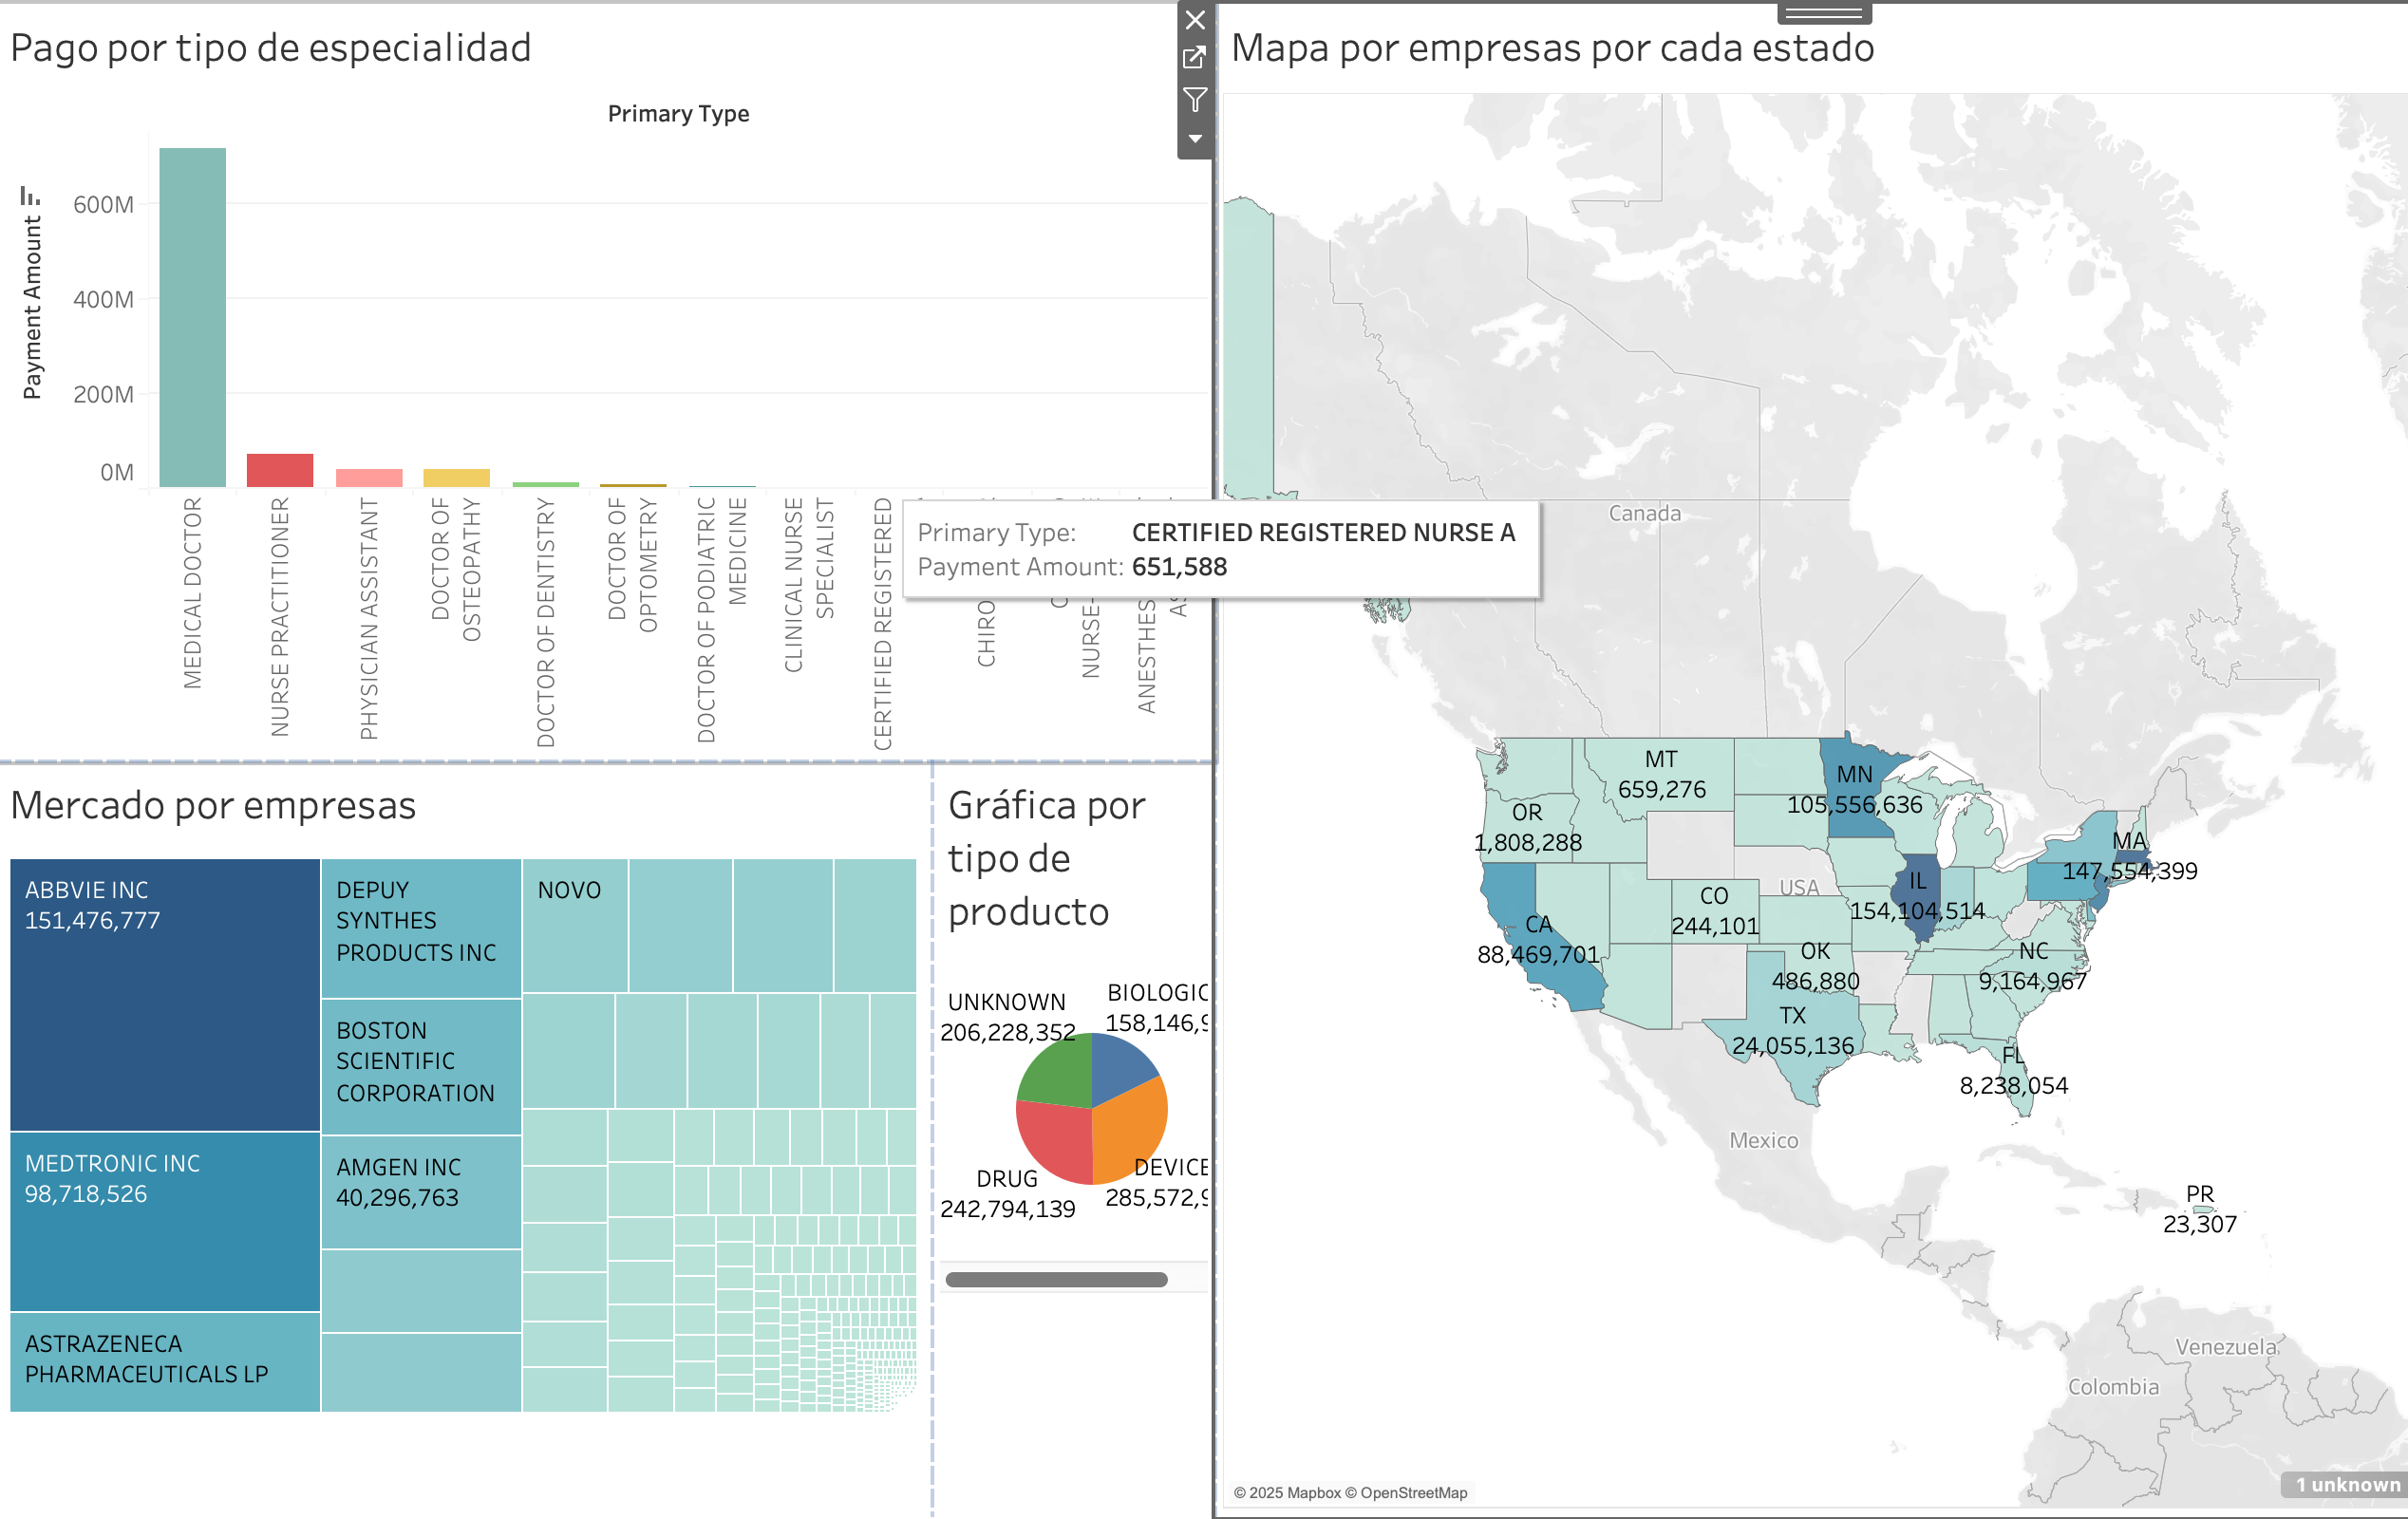

In [40]:
from IPython.display import Image, display


display(Image(filename="/content/Dashboard1.png"))

Test del modelo:
- Mapa por estado: Tiene como etiqueta predicción vs real por cada estado.
- Grafica de barras tipo de producto: Compara la predicción vs real por cada tipo de producto.
- Grafica por especialidad: Compara la predicción vs lo observado de cada especialidad medica.


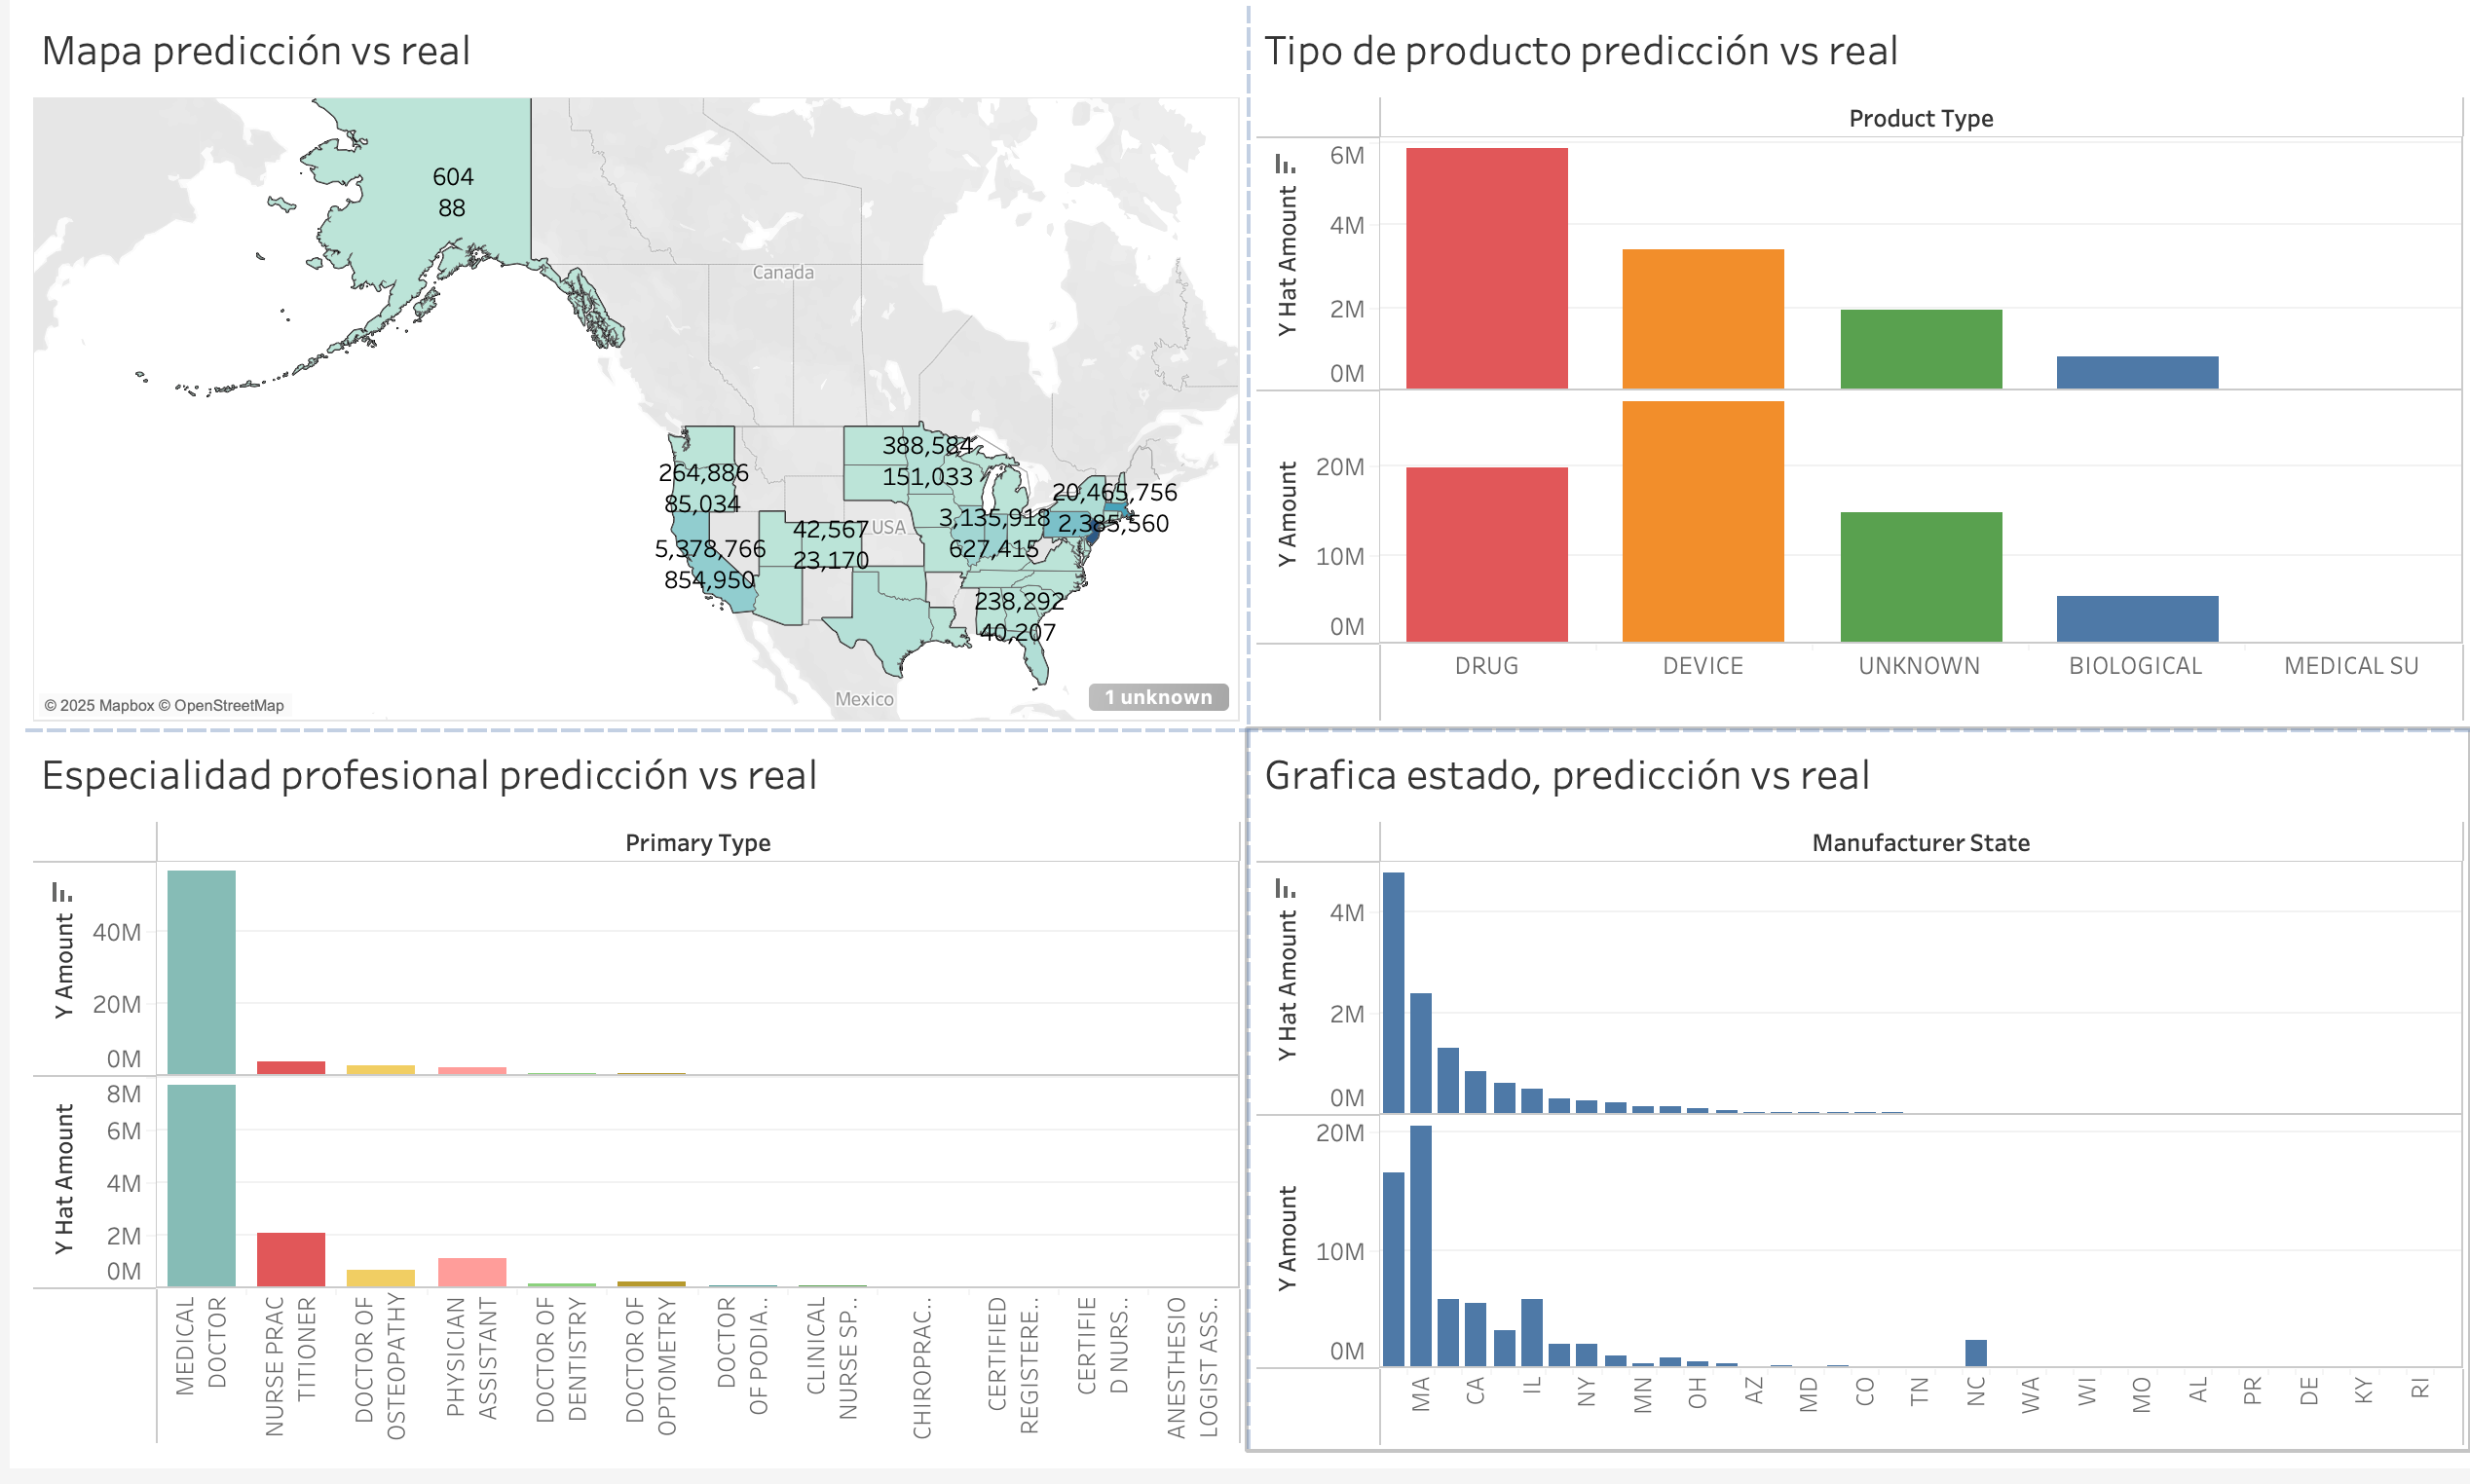

In [41]:
display(Image(filename="/content/Dashboard2.png"))